In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import datetime as dt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings ('ignore')

In [2]:
#Import csv file with pandas
df=pd.read_csv('/Users/robertpatton/Desktop/Desktop - Robert’s MacBook Pro/D213/medical_time_series .csv', index_col=0)

In [3]:
#Look at first 5 data entries
df.head(5)

,Revenue
Day,
1,0.000000
2,-0.292356
3,-0.327772
4,-0.339987
5,-0.124888


In [4]:
#Looking for missing/null values
df.isnull().sum()

Revenue    0
dtype: int64

In [5]:
#Looking for duplicated values
df.duplicated().value_counts()

False    731
dtype: int64

In [6]:
#Look at shape of data
df.shape

(731, 1)

In [7]:
#Get data statistics info
df.describe()

,Revenue
count,731.000000
mean,14.179608
std,6.959905
min,-4.423299
25%,11.121742
50%,15.951830
75%,19.293506
max,24.792249


In [8]:
#Create datetime index
df['Date']=(pd.date_range(start=datetime(2022,1,1),
                          periods=df.shape[0], freq='24H'))
#Set date as an index
df.set_index('Date', inplace=True)
df

,Revenue
Date,
2022-01-01,0.000000
2022-01-02,-0.292356
2022-01-03,-0.327772
2022-01-04,-0.339987
2022-01-05,-0.124888
...,...
2023-12-28,15.722056
2023-12-29,15.865822
2023-12-30,15.708988


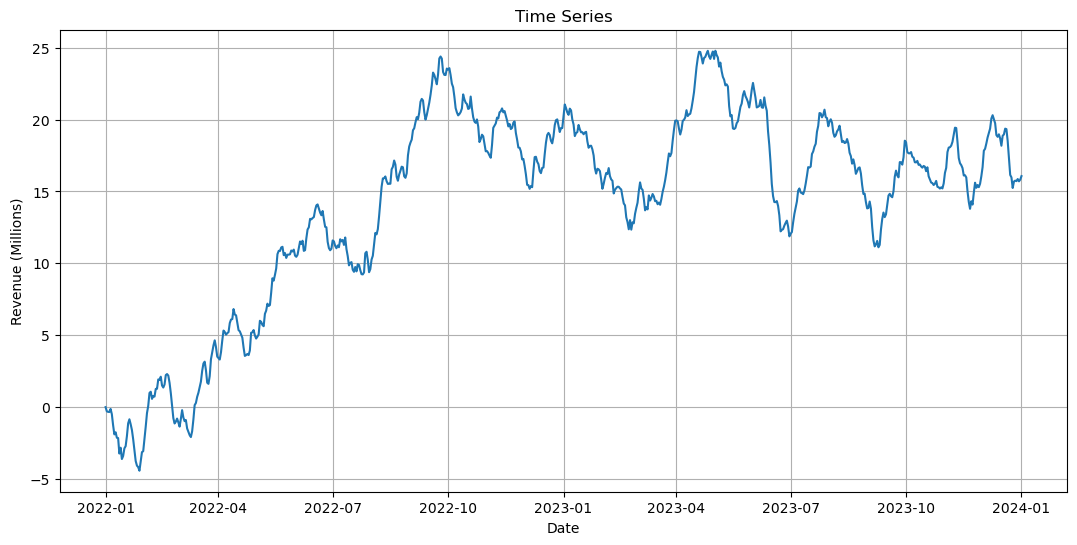

In [9]:
#Visualize the data
plt.figure(figsize=(13,6))
plt.plot(df.Revenue)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Revenue (Millions)')
plt.grid(True)
plt.show()

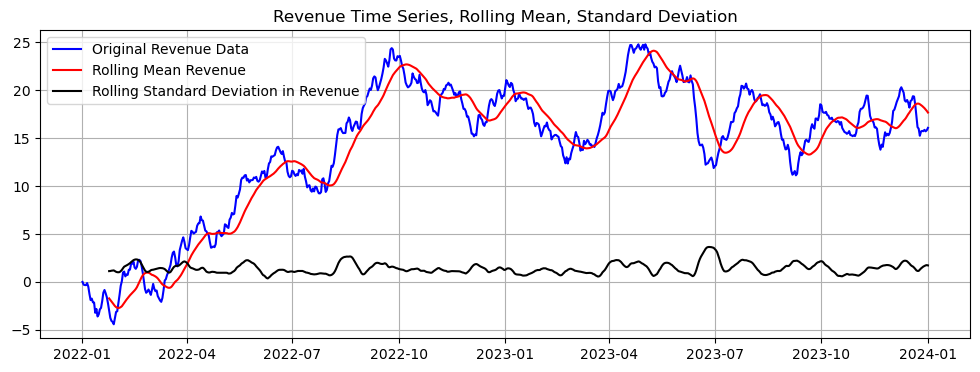

In [10]:
#Create rolling mean graph
plt.figure(figsize=(12,4))
rolling_mean=df.rolling(24).mean()
rolling_std=df.rolling(24).std()
plt.plot(df, color="blue",label="Original Revenue Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Revenue")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Revenue")
plt.title("Revenue Time Series, Rolling Mean, Standard Deviation")
plt.grid(True)
plt.legend(loc="best")

In [11]:
#Split non-stationary data
X_train=df.loc[:'2023-08-08']
X_test=df.loc['2023-08-09':]
print('X_test Shape', X_train.shape)
print('X_test Shape', X_test.shape)

X_test Shape (585, 1)
X_test Shape (146, 1)


In [12]:
#Export train and test sets of non stationary data
X_train.to_csv('/Users/robertpatton/Desktop/X_train.csv')
X_test.to_csv('/Users/robertpatton/Desktop/X_test.csv')

In [13]:
#Run Augmented Dickey-Fuller test to check for stationarity
df_adf=adfuller(df['Revenue'], autolag='AIC')
dfoutput=pd.Series(df_adf[0:4], index=['Test Statistic', 'p-value', '# of lags', 'No. Observations'])

for key, value in df_adf[4].items():
    dfoutput['Critical Value (%s) '%key]= value


print(dfoutput)

Test Statistic            -2.218319
p-value                    0.199664
# of lags                  1.000000
No. Observations         729.000000
Critical Value (1%)       -3.439352
Critical Value (5%)       -2.865513
Critical Value (10%)      -2.568886
dtype: float64


In [14]:
#Transform data into stationary form
df_trans=df.diff().dropna()
df_trans.head()

,Revenue
Date,
2022-01-02,-0.292356
2022-01-03,-0.035416
2022-01-04,-0.012215
2022-01-05,0.215100
2022-01-06,-0.366702


In [15]:
#Run Augmented Dickey-Fuller test to check for stationarity
dftrans_adf=adfuller(df_trans['Revenue'], autolag='AIC')
dfoutput=pd.Series(dftrans_adf[0:4], index=['Test Statistic', 'p-value', '# of lags', 'No. Observations'])

for key, value in dftrans_adf[4].items():
    dfoutput['Critical Value (%s) '%key]= value


print(dfoutput)

Test Statistic          -1.737477e+01
p-value                  5.113207e-30
# of lags                0.000000e+00
No. Observations         7.290000e+02
Critical Value (1%)     -3.439352e+00
Critical Value (5%)     -2.865513e+00
Critical Value (10%)    -2.568886e+00
dtype: float64


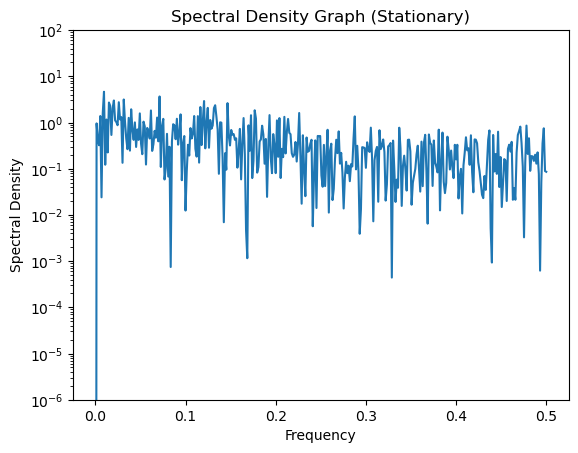

In [16]:
#Display spectral density of transformed data
f, Pxx_den= signal.periodogram(df_trans['Revenue'])
plt.semilogy(f, Pxx_den)
plt.ylim(1e-6, 1e2)
plt.title('Spectral Density Graph (Stationary)')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

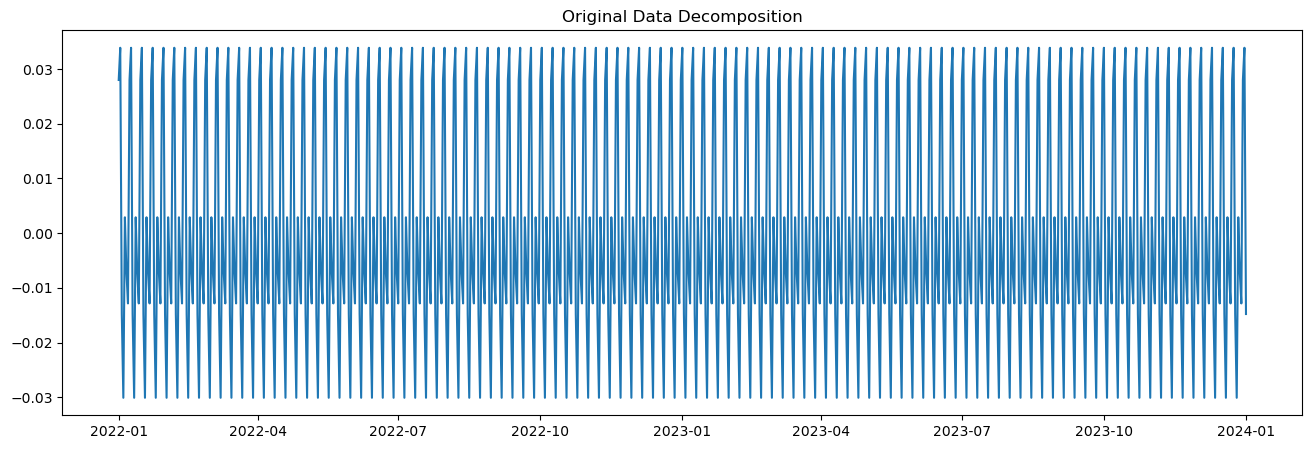

In [17]:
#Look for prescence of a seasonal component by decomposing data and plotting
decomposed_data= seasonal_decompose(df['Revenue'])
plt.figure(figsize = [16,5])
plt.title('Original Data Decomposition')
plt.plot(decomposed_data.seasonal)

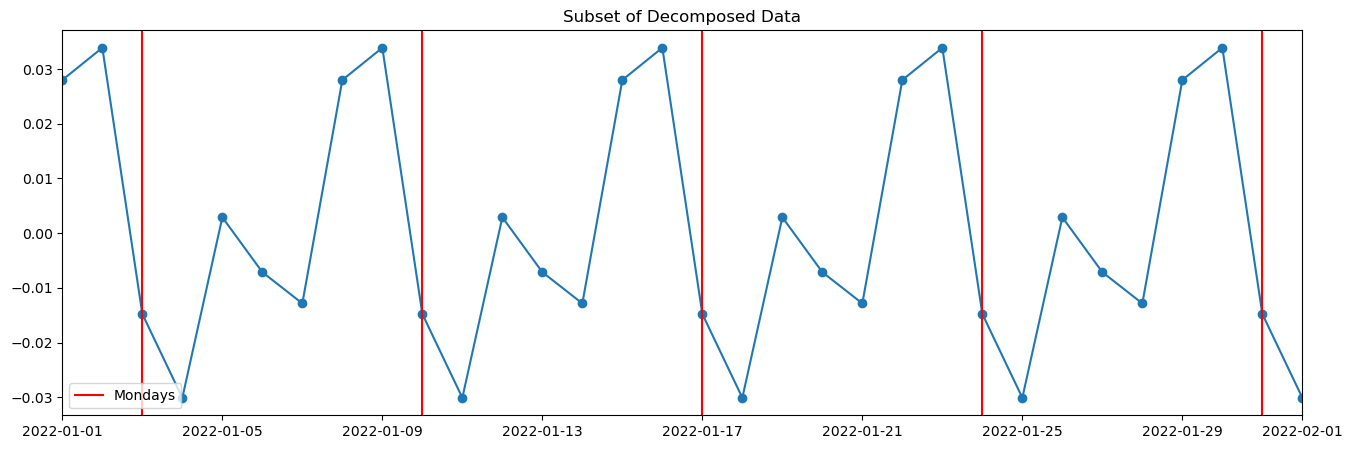

In [18]:
#View a subset of above graph to identify seasonality
plt.figure(figsize = [16,5])
# Plot seasonal component of the data
plt.plot(decomposed_data.seasonal, marker='o')
plt.title('Subset of Decomposed Data')
plt.xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-02-01'))
#Red lines = Mondays
plt.axvline(x=pd.to_datetime('2022-01-03'), color='red', label='Mondays')
plt.axvline(x=pd.to_datetime('2022-01-10'), color='red')
plt.axvline(x=pd.to_datetime('2022-01-17'), color='red')
plt.axvline(x=pd.to_datetime('2022-01-24'), color='red')
plt.axvline(x=pd.to_datetime('2022-01-31'), color='red')
plt.legend(loc="best");

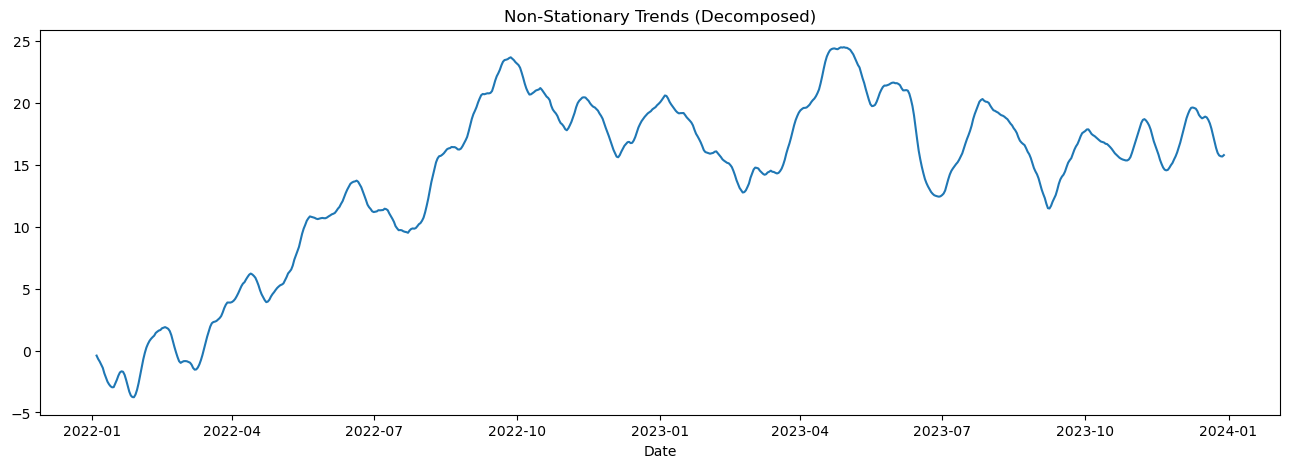

In [19]:
#Look for trends in data
plt.figure(figsize = [16,5])
plt.title('Non-Stationary Trends (Decomposed)')
plt.xlabel('Date')
plt.plot(decomposed_data.trend);

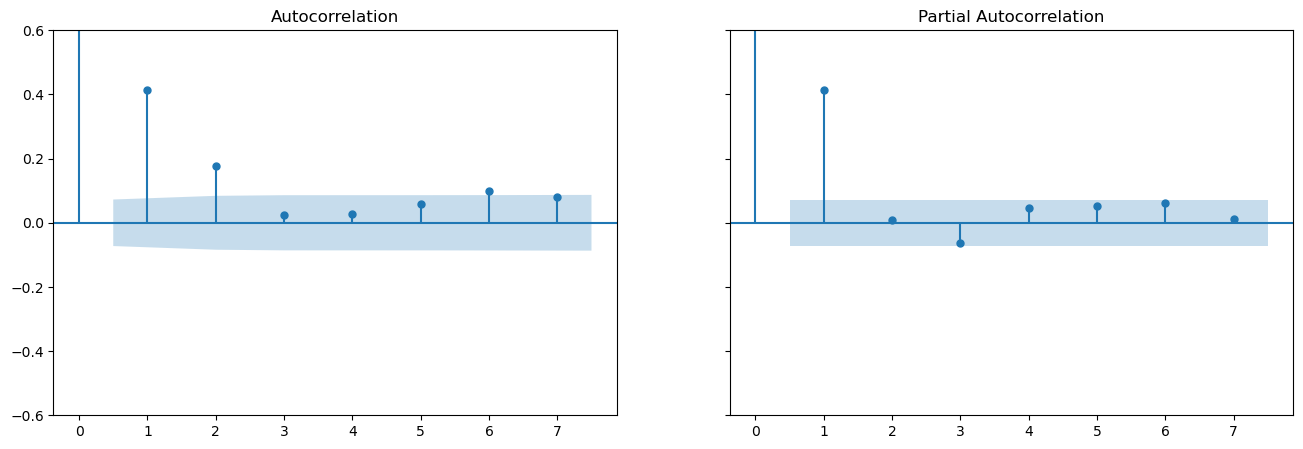

In [20]:
#Create an acf and pacf plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5], sharey=True)
plot_acf(df_trans, lags=7, ax=ax1)
plot_pacf(df_trans, lags=7, ax=ax2)
plt.ylim(-0.6, 0.6);

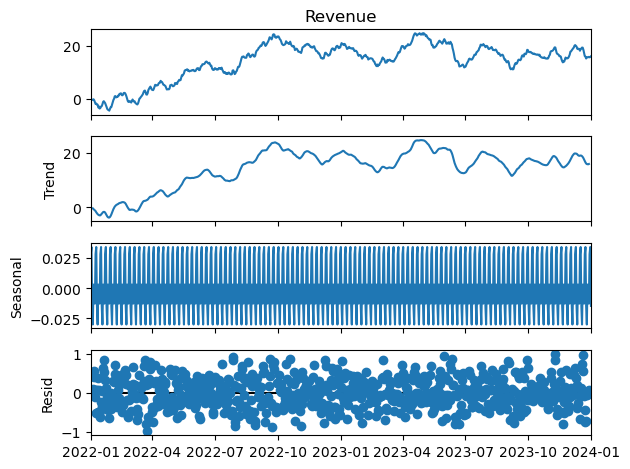

In [21]:
#Plot decomposed data
decomposed_data.plot()
plt.show()

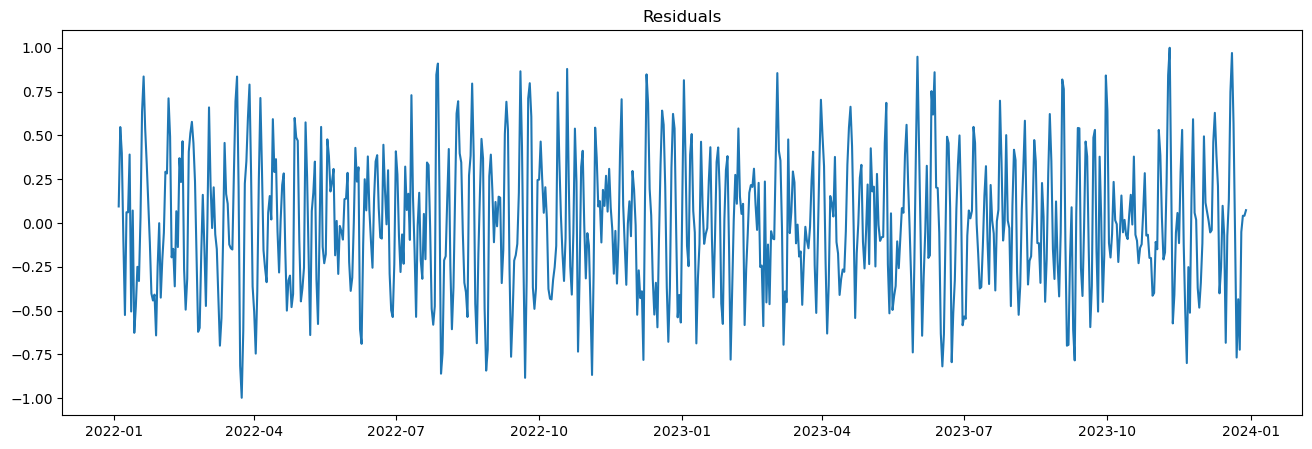

In [22]:
#Plot and confirm lack of trends in residuals
plt.figure(figsize = [16,5])
plt.title('Residuals')
plt.plot(decomposed_data.resid);

In [23]:
#Split transformed data into train and test sets
X_stat_train=df_trans.loc[:'2023-08-08']
X_stat_test=df_trans.loc['2023-08-09':]
print('X_stat_train Shape', X_stat_train.shape)
print('X_stat_test Shape', X_stat_test.shape)

X_stat_train Shape (584, 1)
X_stat_test Shape (146, 1)


In [24]:
X_stat_train

,Revenue
Date,
2022-01-02,-0.292356
2022-01-03,-0.035416
2022-01-04,-0.012215
2022-01-05,0.215100
2022-01-06,-0.366702
...,...
2023-08-04,-0.694370
2023-08-05,-0.282765
2023-08-06,0.104732


In [25]:
X_stat_test

,Revenue
Date,
2023-08-09,0.263991
2023-08-10,-0.588690
2023-08-11,-0.550427
2023-08-12,0.081477
2023-08-13,-0.146587
...,...
2023-12-28,-0.032693
2023-12-29,0.143766
2023-12-30,-0.156834


In [26]:
#Export train and test sets of stationary data
X_stat_train.to_csv('/Users/robertpatton/Desktop/X_stat_train.csv')
X_stat_test.to_csv('/Users/robertpatton/Desktop/X_stat_test.csv')

In [27]:
#Run auto ARIMA
model=pm.auto_arima(df,
                    seasonal=True, m=90,
                    d=1, D=1,
                    start_p=1, start_q=1,
                    max_p=2, max_q=2,
                    max_P=2, max_Q=2,
                    trace=True,
                    error_action='ignore',
                    supress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[90]             : AIC=inf, Time=245.56 sec
 ARIMA(0,1,0)(0,1,0)[90]             : AIC=1344.172, Time=12.36 sec
 ARIMA(1,1,0)(1,1,0)[90]             : AIC=inf, Time=35.14 sec
 ARIMA(0,1,1)(0,1,1)[90]             : AIC=inf, Time=160.14 sec
 ARIMA(0,1,0)(1,1,0)[90]             : AIC=inf, Time=25.80 sec
 ARIMA(0,1,0)(0,1,1)[90]             : AIC=inf, Time=74.64 sec
 ARIMA(0,1,0)(1,1,1)[90]             : AIC=inf, Time=155.78 sec
 ARIMA(1,1,0)(0,1,0)[90]             : AIC=1228.526, Time=13.18 sec
 ARIMA(1,1,0)(0,1,1)[90]             : AIC=inf, Time=152.56 sec
 ARIMA(1,1,0)(1,1,1)[90]             : AIC=inf, Time=142.23 sec
 ARIMA(2,1,0)(0,1,0)[90]             : AIC=1230.491, Time=13.42 sec
 ARIMA(1,1,1)(0,1,0)[90]             : AIC=1230.496, Time=14.76 sec
 ARIMA(0,1,1)(0,1,0)[90]             : AIC=1247.950, Time=13.36 sec
 ARIMA(2,1,1)(0,1,0)[90]             : AIC=1231.394, Time=20.59 sec
 ARIMA(1,1,0)(0,1,0)[90] intercept   : A

In [28]:
#Run ARIMA model on best fit model
model=SARIMAX(X_train['Revenue'], order=(1,1,0), seasonal_order=(1,1,0,90))
results=model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11649D-01    |proj g|=  2.97788D-01


 This problem is unconstrained.



At iterate    5    f=  6.99649D-01    |proj g|=  4.35447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   4.331D-05   6.996D-01
  F =  0.69964303722090848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  585
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 90)   Log Likelihood                -409.291
Date:                            Fri, 10 May 2024   AIC                            824.582
Time:                                    09:59:02   BIC                            837.190
Sample:                                01-01-2022   HQIC                           829.532
                                     - 08-08-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3818      0.040      9.642      0.000       0.304       0.459
ar.S.L90      -0.4655      0.043    -10.942      0.000      -0.549      -0.382
sigma2         0.2936      0.020     14.400      0.000       0.254       0.334
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.69   Prob(JB):                         0.35
Heteroskedasticity (H):               1.06   Skew:                            -0.05
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
#Calculate mean absolute error
mae=np.mean(np.abs(results.resid))
print("Mean absolute error", mae)

Mean absolute error 0.44840928413811953


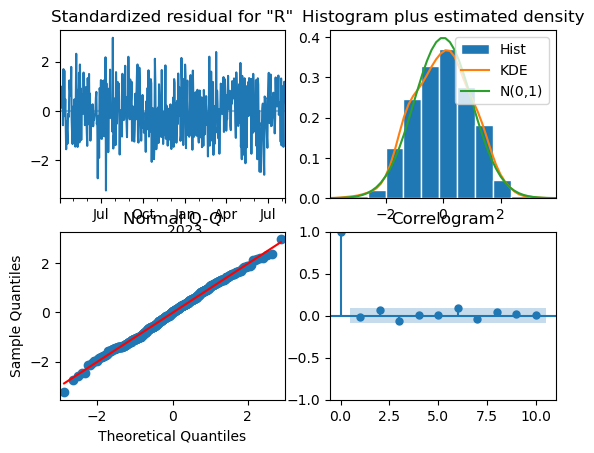

In [30]:
#Plot diagnostic graphs
results.plot_diagnostics()
plt.show()

In [31]:
#Generate forecast
diff_forecast=results.get_forecast(steps=30)
mean_forecast= diff_forecast.predicted_mean
confidence_intervals=diff_forecast.conf_int()
lower_limits=confidence_intervals.loc[:,'lower Revenue']
upper_limits=confidence_intervals.loc[:, 'upper Revenue']
#Generate prediction
prediction=results.get_prediction(start=len(df), end=len(df)+89)
mean_prediction=prediction.predicted_mean
confidence_intervals=prediction.conf_int()
lower_limits=confidence_intervals.loc[:,'lower Revenue']
upper_limits=confidence_intervals.loc[:,'upper Revenue']
#Display tail of mean prediction
mean_prediction.tail(30)

2024-03-02    19.077558
2024-03-03    19.293721
2024-03-04    19.296007
2024-03-05    19.152047
2024-03-06    19.688508
2024-03-07    19.407824
2024-03-08    19.118870
2024-03-09    18.071761
2024-03-10    17.463475
2024-03-11    16.584951
2024-03-12    15.657092
2024-03-13    15.057474
2024-03-14    14.927157
2024-03-15    15.096296
2024-03-16    15.270609
2024-03-17    15.209481
2024-03-18    14.975928
2024-03-19    14.490436
2024-03-20    14.778034
2024-03-21    14.738781
2024-03-22    14.978323
2024-03-23    15.401493
2024-03-24    15.767598
2024-03-25    15.724819
2024-03-26    15.286470
2024-03-27    15.381765
2024-03-28    15.282555
2024-03-29    15.576415
2024-03-30    16.074651
2024-03-31    16.573085
Freq: D, Name: predicted_mean, dtype: float64

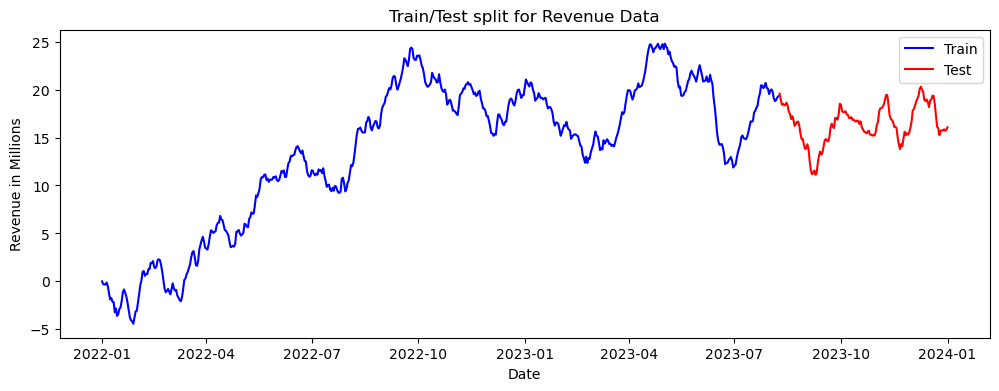

In [32]:
#Visual of train/test split on non-stationary data
plt.figure(figsize=(12,4))
plt.plot(X_train, label='Train', color = "blue")
plt.plot(X_test, label= 'Test', color = "red")
plt.title("Train/Test split for Revenue Data")
plt.ylabel("Revenue in Millions")
plt.xlabel('Date')
plt.legend()
plt.show()

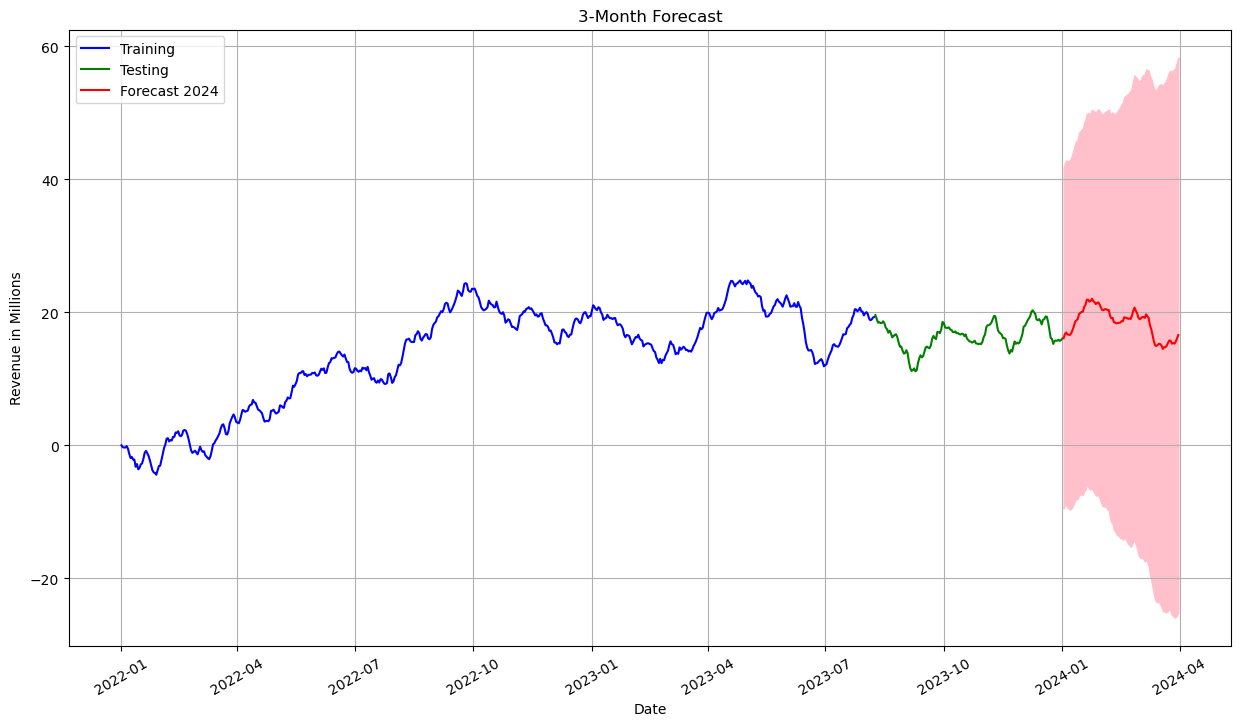

In [33]:
#Create graph of test, train, and forecast
plt.figure(figsize=(15,8))
plt.plot(X_train, label='Training', color='b')
plt.plot(X_test, label='Testing', color='g')
plt.plot(mean_prediction, label='Forecast 2024', color='r')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.title('3-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions')
plt.grid()
plt.xticks(rotation=30, fontsize=10)
plt.legend(loc='upper left')